In [1]:
import scipy.io as spio

from __future__ import division

import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from matplotlib import ticker
import matplotlib as mpl
from os import path

from scipy.io import loadmat

from wyrm.types import Data

from wyrm import plot
#plot.beautify()
from wyrm.types import Data
from wyrm import processing as proc

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import metrics
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score

DEBUG:matplotlib.backends:backend module://ipykernel.pylab.backend_inline version unknown


In [2]:
TRAIN_A = '../BCI_Comp_III_Wads_2004/data/Subject_A_Train.mat'
TRAIN_B = '../BCI_Comp_III_Wads_2004/data/Subject_B_Train.mat'

TEST_A = '../BCI_Comp_III_Wads_2004/data/Subject_A_Test.mat'
TEST_B = '../BCI_Comp_III_Wads_2004/data/Subject_B_Test.mat'

TRUE_LABELS_A = 'WQXPLZCOMRKO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDGYEGOA5VHNEHBTXOO1TDOILUEE5BFAEEXAW_K4R3MRU'
TRUE_LABELS_B = 'MERMIROOMUHJPXJOHUVLEORZP3GLOO7AUFDKEFTWEOOALZOP9ROCGZET1Y19EWX65QUYU7NAK_4YCJDVDNGQXODBEV2B5EFDIDNR'

MATRIX = ['abcdef',
          'ghijkl',
          'mnopqr',
          'stuvwx',
          'yz1234',
          '56789_']

MARKER_DEF_TRAIN = {'target': ['target'], 'nontarget': ['nontarget']}
MARKER_DEF_TEST = {'flashing': ['flashing']}

SEG_IVAL = [0, 700]

In [3]:
def load_bci_data(filename):
    """Load the BCI Competition III Data Set 2.
    This method loads the data set and converts it into Wyrm's ``Data``
    format. Before you use it, you have to download the data set in
    Matlab format and unpack it. The directory with the extracted files
    must contain the ``Subject_*.mat``- and the ``eloc64.txt`` files.
    .. note::
        If you need the true labels of the test sets, you'll have to
        download them separately from
        http://bbci.de/competition/iii/results/index.html#labels
    Parameters
    ----------
    filename : str
        The path to the matlab file to load
    Returns
    -------
    cnt : continuous `Data` object
    Examples
    --------
    >>> dat = load_bcicomp3_ds2('/home/foo/data/Subject_A_Train.mat')
    """
    STIMULUS_CODE = {
        0 : "blankMatrix",
        # cols from left to right
        1 : "agmsy5",
        2 : "bhntz6",
        3 : "ciou17",
        4 : "djpv28",
        5 : "ekqw39",
        6 : "flrx4_",
        # rows from top to bottom
        7 : "abcdef",
        8 : "ghijkl",
        9 : "mnopqr",
        10: "stuvwx",
        11: "yz1234",
        12: "56789_"
        }

    # load the matlab data
    data_mat = loadmat(filename)
    # load the channel names (the same for all datasets
    eloc_file = path.sep.join([path.dirname(filename), 'eloc64.txt'])
    with open(eloc_file) as fh:
        data = fh.read()
    channels = []
    for line in data.splitlines():
        if line:
            chan = line.split()[-1]
            chan = chan.replace('.', '')
            channels.append(chan)
    # fix the channel names, some letters have the wrong capitalization
    for i, s in enumerate(channels):
        s2 = s.upper()
        s2 = s2.replace('Z', 'z')
        s2 = s2.replace('FP', 'Fp')
        channels[i] = s2
    # The signal is recorded with 64 channels, bandpass filtered
    # 0.1-60Hz and digitized at 240Hz. The format is Character Epoch x
    # Samples x Channels
    data = data_mat['Signal']
    data = data.astype('double')
    # For each sample: 1 if a row/colum was flashed, 0 otherwise
    flashing = data_mat['Flashing'].reshape(-1)
    #flashing = np.flatnonzero((np.diff(a) == 1)) + 1
    ##Creates an array where only the initial intensifications of each series appear
    tmp = []
    for i, _ in enumerate(flashing):
        if i == 0:
            tmp.append(flashing[i])
            continue
        if flashing[i] == flashing[i-1] == 1:
            tmp.append(0)
            continue
        tmp.append(flashing[i])
    flashing = np.array(tmp)
    # For each sample: 0 when no row/colum was intensified,
    # 1..6 for intensified columns, 7..12 for intensified rows
    stimulus_code = data_mat['StimulusCode'].reshape(-1)
    stimulus_code = stimulus_code[flashing == 1]
    # 0 if no row/col was intensified or the intensified did not contain
    # the target character, 1 otherwise
    stimulus_type = data_mat.get('StimulusType', np.array([])).reshape(-1)
    # The target characters
    target_chars = data_mat.get('TargetChar', np.array([])).reshape(-1)
    fs = 240
    data = data.reshape(-1, 64)
    timeaxis = np.linspace(0, data.shape[0] / fs * 1000, data.shape[0], endpoint=False)
    dat = Data(data=data, axes=[timeaxis, channels], names=['time', 'channel'], units=['ms', '#'])
    dat.fs = fs
    # preparing the markers
    target_mask = np.logical_and((flashing == 1), (stimulus_type == 1)) if len(stimulus_type) > 0 else []
    nontarget_mask = np.logical_and((flashing == 1), (stimulus_type == 0)) if len(stimulus_type) > 0 else []
    flashing = (flashing == 1)
    flashing = [[i, 'flashing'] for i in timeaxis[flashing]]
    targets = [[i, 'target'] for i in timeaxis[target_mask]]
    nontargets = [[i, 'nontarget'] for i in timeaxis[nontarget_mask]]
    dat.stimulus_code = stimulus_code[:]
    stim = []
    for i,_ in enumerate(flashing):
        stim.append([flashing[i][0], STIMULUS_CODE[stimulus_code[i]]])
    stimulus_code = stim
    #stimulus_code = zip([t for t, _ in flashing], [STIMULUS_CODE[i] for i in stimulus_code])
    #Raises error "TypeError: '<' not supported between instances of 'tuple' and 'list'" when calling sort() 
    #stimulus_code =[[t for t,_ in flashing], [STIMULUS_CODE[i] for i in stimulus_code]]
    #print(type(stimulus_code), type(flashing), type(targets), type(nontargets))
    markers = flashing[:]
    markers.extend(targets)
    markers.extend(nontargets)
    markers.extend(stimulus_code)
    markers.sort()
    dat.markers = markers[:]
    return dat


In [4]:
def preprocessing_simple(dat, MRK_DEF, *args, **kwargs):
    """Simple preprocessing that reaches 97% accuracy.
    """
    fs_n = dat.fs / 2
    b, a = proc.signal.butter(5, [10 / fs_n], btype='low')
    dat = proc.filtfilt(dat, b, a)
   
    dat = proc.subsample(dat, 20)
    epo = proc.segment_dat(dat, MRK_DEF, SEG_IVAL)
    fv = proc.create_feature_vectors(epo)
    return fv, epo

In [5]:
dat_train = load_bci_data(TRAIN_A)
dat_test = load_bci_data(TEST_A)

In [6]:
fv_train, epo_train = preprocessing_simple(dat_train, MARKER_DEF_TRAIN, SEG_IVAL)
fv_test, _ = preprocessing_simple(dat_test, MARKER_DEF_TEST, SEG_IVAL)

In [7]:
x = fv_train.data #data
y = fv_train.axes[0] #labels
x_test = fv_test.data
y_test = fv_test.axes[0]
X_train, X_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.3, train_size = 0.7)

In [8]:
Subject = {}
sb = ['A', 'B']
for subject in range(2):
    Subject[sb[subject]] = {}
    sbj = Subject[sb[subject]]
    if subject == 0:
        training_set = TRAIN_A
        testing_set = TEST_A
        labels = TRUE_LABELS_A
    else:
        training_set = TRAIN_B
        testing_set = TEST_B
        labels = TRUE_LABELS_B
    dat_train = load_bci_data(training_set)
    dat_test = load_bci_data(testing_set)

    fv_train, epo_train = preprocessing_simple(dat_train, MARKER_DEF_TRAIN, SEG_IVAL)
    fv_test, _ = preprocessing_simple(dat_test, MARKER_DEF_TEST, SEG_IVAL)

    sbj['fv_train'] = fv_train
    sbj['fv_test'] = fv_test
    
    x = fv_train.data #data
    y = fv_train.axes[0] #labels
    x_test = fv_test.data
    y_test = fv_test.axes[0]
    X_train, X_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.3, train_size = 0.7)
    sbj['X_train'], sbj['X_valid'], sbj['y_train'], sbj['y_valid'] = train_test_split(x, y, test_size = 0.3, train_size = 0.7)
#     sbj['X_train'] = X_train; sbj['y_train'] = y_train
#     sbj['X_valid'] = X_valid; sbj['y_valid'] = y_valid
    sbj['x_test'] = x_test
    

### LDA Classifier

In [9]:
class LDA():
    'Linear Discriminant Classifier'
    def __init__(self, w='w', b='b'):
        self.w = w
        self.b = b
    def fit(self, x, y):
        """Fit LinearDiscriminantAnalysis model according
        to the given training data.'
        
        Arguments: 
        ----------
        x: array-like, shape (n_samples, n_features)
            Training data
        y: array, shape (n_samples)
            Training labels
        """
    
        # Means for each class
        mu1 = x[y == 0].mean(axis = 0)
        mu2 = x[y == 1].mean(axis = 0)
        mu = mu1 + mu2

        # Covariance matrices for each class
        cov1 = np.cov(x[y == 0], rowvar = False)
        cov2 = np.cov(x[y == 1], rowvar = False)
        covm = cov1 + cov2

        # Weight vector
        self.w = np.dot(np.linalg.pinv(covm), (mu2 - mu1))

        # Bias term
        self.b = -0.5 * np.dot(self.w.transpose(), mu)
        
    def predict_proba(self, x):
        """Estimates the probability
        Arguments: 
        ----------
        x: array-like, shape (n_samples, n_features)
            Training data
        Returns:
        --------
        y: array, shape (n_samples)
            Estimated probabilities
        """
        y = np.dot(x,self.w) + self.b
        prob = np.copy(y) 
        prob *= -1
        np.exp(prob, prob)
        prob += 1
        np.reciprocal(prob, prob)
        return np.column_stack([1 - prob, prob])
#         return y
    
    def predict_class(self, x):
        # Binarization - class prediction
        pred = np.dot(x,self.w) + self.b
#         pred = self.predict_proba(x)
        target_mask = [pred > 0]
        nontarget_mask = [pred <= 0]
        pred_class = pred.copy()
        pred_class[target_mask] = 1
        pred_class[nontarget_mask] = 0
        return pred_class
    def score(self, x, y):
        pred = self.predict_class(x)
        n = pred[pred == y].shape[0]
        return n/pred.shape[0]   
    def get_params(self, deep = True):
        return {'w': self.w, 'b': self.b}
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self


# Testing different solvers

In [10]:
import time 
cv = StratifiedShuffleSplit(n_splits=10, test_size=0.25)
solvers = ['svd', 'lsqr', 'eigen']
auc = []
methods = []
for sv in solvers:
    cf = LinearDiscriminantAnalysis(solver = sv)
    print('\nSolving for {} solver...'.format((sv)))
    res = cross_val_score(cf, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1, verbose = 3)
    auc.extend(res)
    methods.extend([sv]*len(res))
    
# cf = LDA()
# res = cross_val_score(cf, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1, verbose = 3)
    


Solving for svd solver...


[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   38.2s remaining:   16.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   48.6s finished



Solving for lsqr solver...


[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   22.0s remaining:    9.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   27.4s finished



Solving for eigen solver...


[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   21.7s remaining:    9.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   27.4s finished


In [ ]:
cf = LDA()
res = cross_val_score(cf, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1, verbose = 3)

In [17]:
auc.extend(res)
methods.extend([sv]*len(res))

[array([ 0.8547906 ,  0.84595211,  0.85378463,  0.82839626,  0.83911055,
         0.82643538,  0.85825292,  0.83585642,  0.83310678,  0.83450813]),
 array([ 0.83948591,  0.83842289,  0.85013012,  0.83905349,  0.8448911 ,
         0.86012672,  0.84447169,  0.84858965,  0.85155649,  0.83873218]),
 array([ 0.84778587,  0.8436499 ,  0.83717068,  0.8331228 ,  0.86627963,
         0.83535594,  0.84378904,  0.84331158,  0.86288737,  0.84045283])]

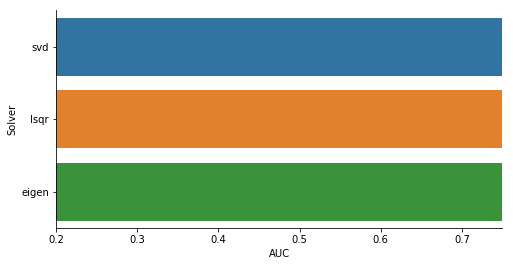

In [23]:
import seaborn as sns
res = pd.DataFrame(data=auc, columns=['AUC'])
res['Solver'] = methods

plt.figure(figsize=[8,4])
sns.barplot(data=res, x='AUC', y = 'Solver')
plt.xlim(0.2, 0.75)
sns.despine()

In [112]:
import time 
solvers = ['svd', 'lsqr', 'eigen']
for subject in sb:
    sbj = Subject[subject]
    scores = []
    predictions = []
    pred_classes = []
    times = []
    classifiers = []
    for sv in solvers:
        cf = LinearDiscriminantAnalysis(solver = sv)
        t_start = time.clock()
        classifiers.append(cf.fit(sbj['X_train'], sbj['y_train']))
        predictions.append(cf.predict_proba(sbj['X_valid']))
        t_end = time.clock()
        pred_classes.append(cf.predict(sbj['X_valid']))
        scores.append(cf.score(sbj['X_valid'], sbj['y_valid']))
        t_diff = t_end - t_start
        times.append(t_diff)
        print('Time for solver {}: {} s'.format(sv, t_diff))
    cf = LDA()
    t_start = time.clock()
    classifiers.append(cf.fit(sbj['X_train'], sbj['y_train']))
    predictions.append(cf.predict_proba(sbj['X_valid']))
    t_end = time.clock()
    pred_classes.append(cf.predict_class(sbj['X_valid']))
    scores.append(cf.score(sbj['X_valid'], sbj['y_valid']))
    t_diff = t_end - t_start
    times.append(t_diff)
    print('Time for solver {}: {} s'.format('fisher', t_diff))
        
    sbj['scores'] = scores
    sbj['predictions'] = predictions
    sbj['pred_classes'] = pred_classes
    sbj['times'] = times
    sbj['classifiers'] = classifiers
solvers.append('fisher')

Time for solver svd: 3.253280070179244 s
Time for solver lsqr: 0.628704532278789 s
Time for solver eigen: 1.0242955308658566 s
Time for solver fisher: 0.7781538764375 s
Time for solver svd: 2.160007350041269 s
Time for solver lsqr: 0.6774361095285713 s
Time for solver eigen: 1.0129285652128601 s
Time for solver fisher: 0.7314930541524518 s


## Curva ROC

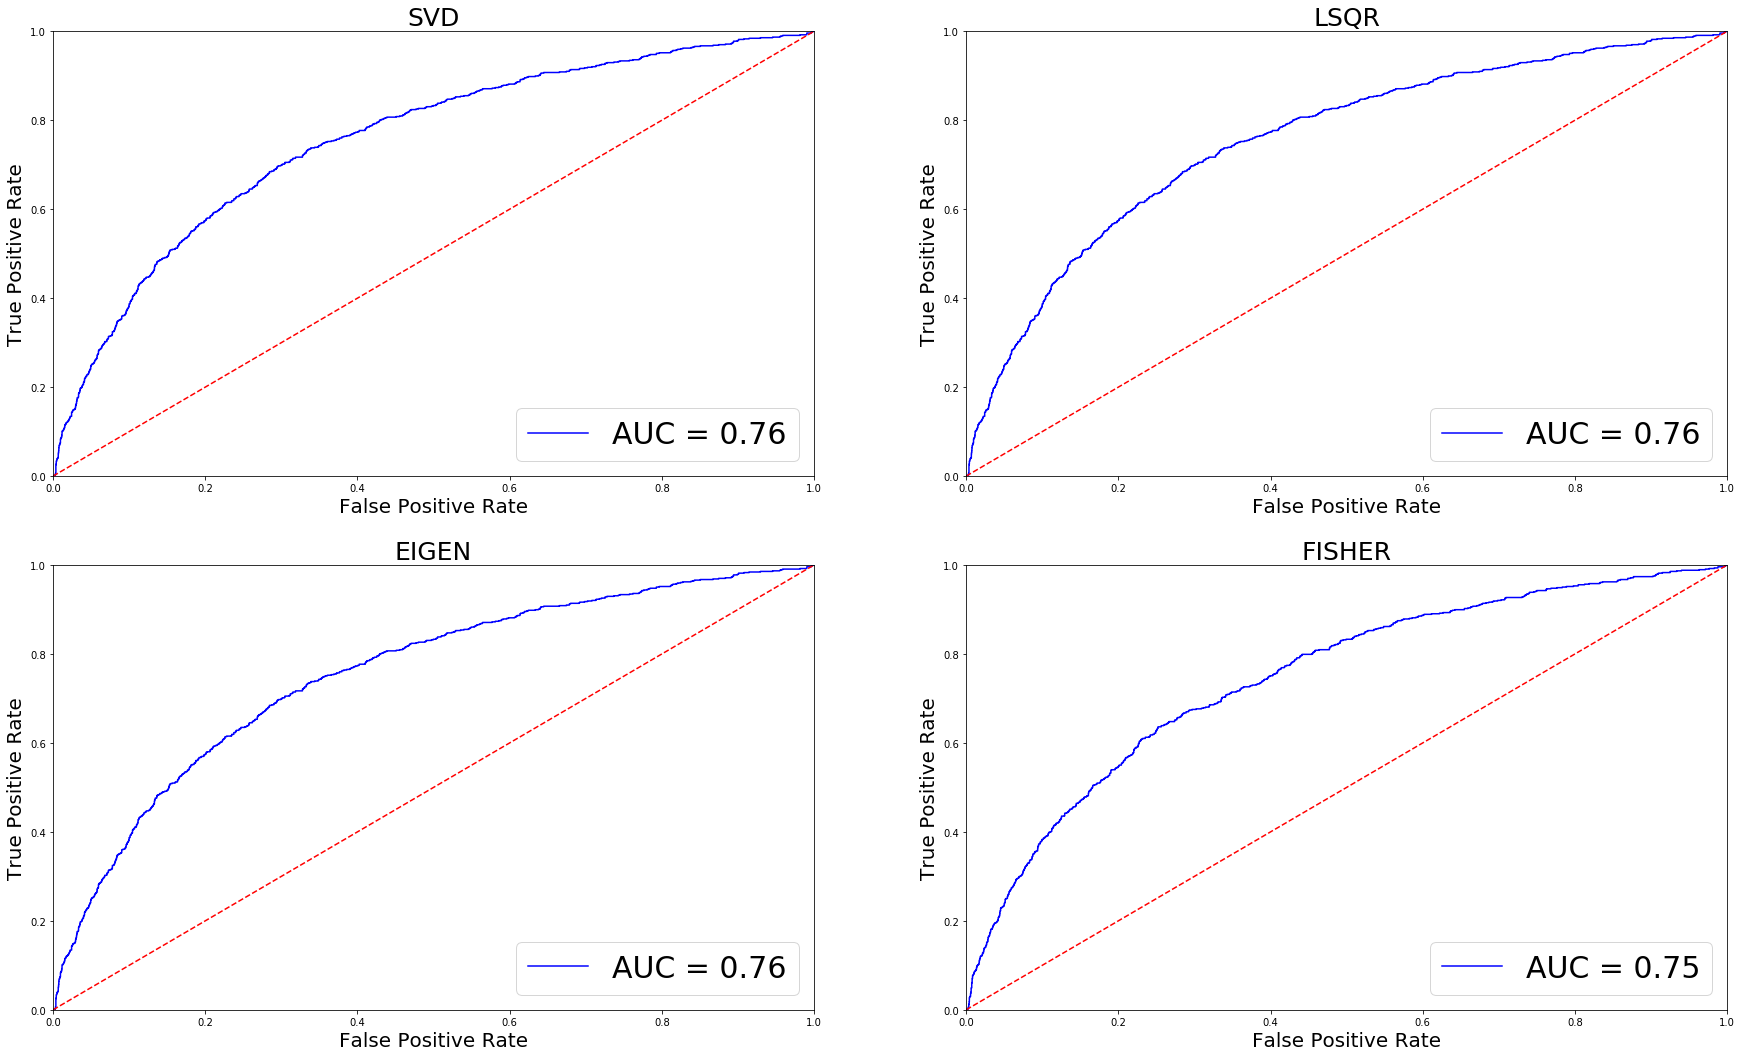

In [92]:
from sklearn import metrics

rocs = []
fprs = []
tprs = []
thresholds = []
for pred in predictions:
    rocs.append(metrics.roc_auc_score(y_valid, pred[:,1], average = 'weighted'))
    fpr, tpr, thr = metrics.roc_curve(y_valid, pred[:,1], pos_label=1)
#     rocs.append(metrics.roc_auc_score(y_test, pred, average = 'weighted'))
#     fpr, tpr, thr = metrics.roc_curve(y_test, pred, pos_label=1)
    fprs.append(fpr)
    tprs.append(tpr)
    thresholds.append(thr)
fig = plt.figure(figsize = (30,18))
for i, sv in enumerate(solvers):
    sp = (int) ('22'+str(i+1))
    plt.subplot(sp)
    plt.title(str(sv).upper(), fontsize = 25)
    plt.plot(fprs[i], tprs[i], 'b', label = 'AUC = %0.2f' % rocs[i])
    plt.legend(loc = 'lower right', fontsize = 30)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate', fontsize = 20)
    plt.xlabel('False Positive Rate', fontsize = 20)

plt.subplot(224)
auc = metrics.roc_auc_score(y_valid, pred_, average = 'weighted')
fpr, tpr, thr = metrics.roc_curve(y_valid, pred_, pos_label=1)

plt.title('FISHER', fontsize = 25)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % auc)
plt.legend(loc = 'lower right', fontsize = 30)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate', fontsize = 20)
plt.xlabel('False Positive Rate', fontsize = 20)

plt.show()

IndexError: list index out of range

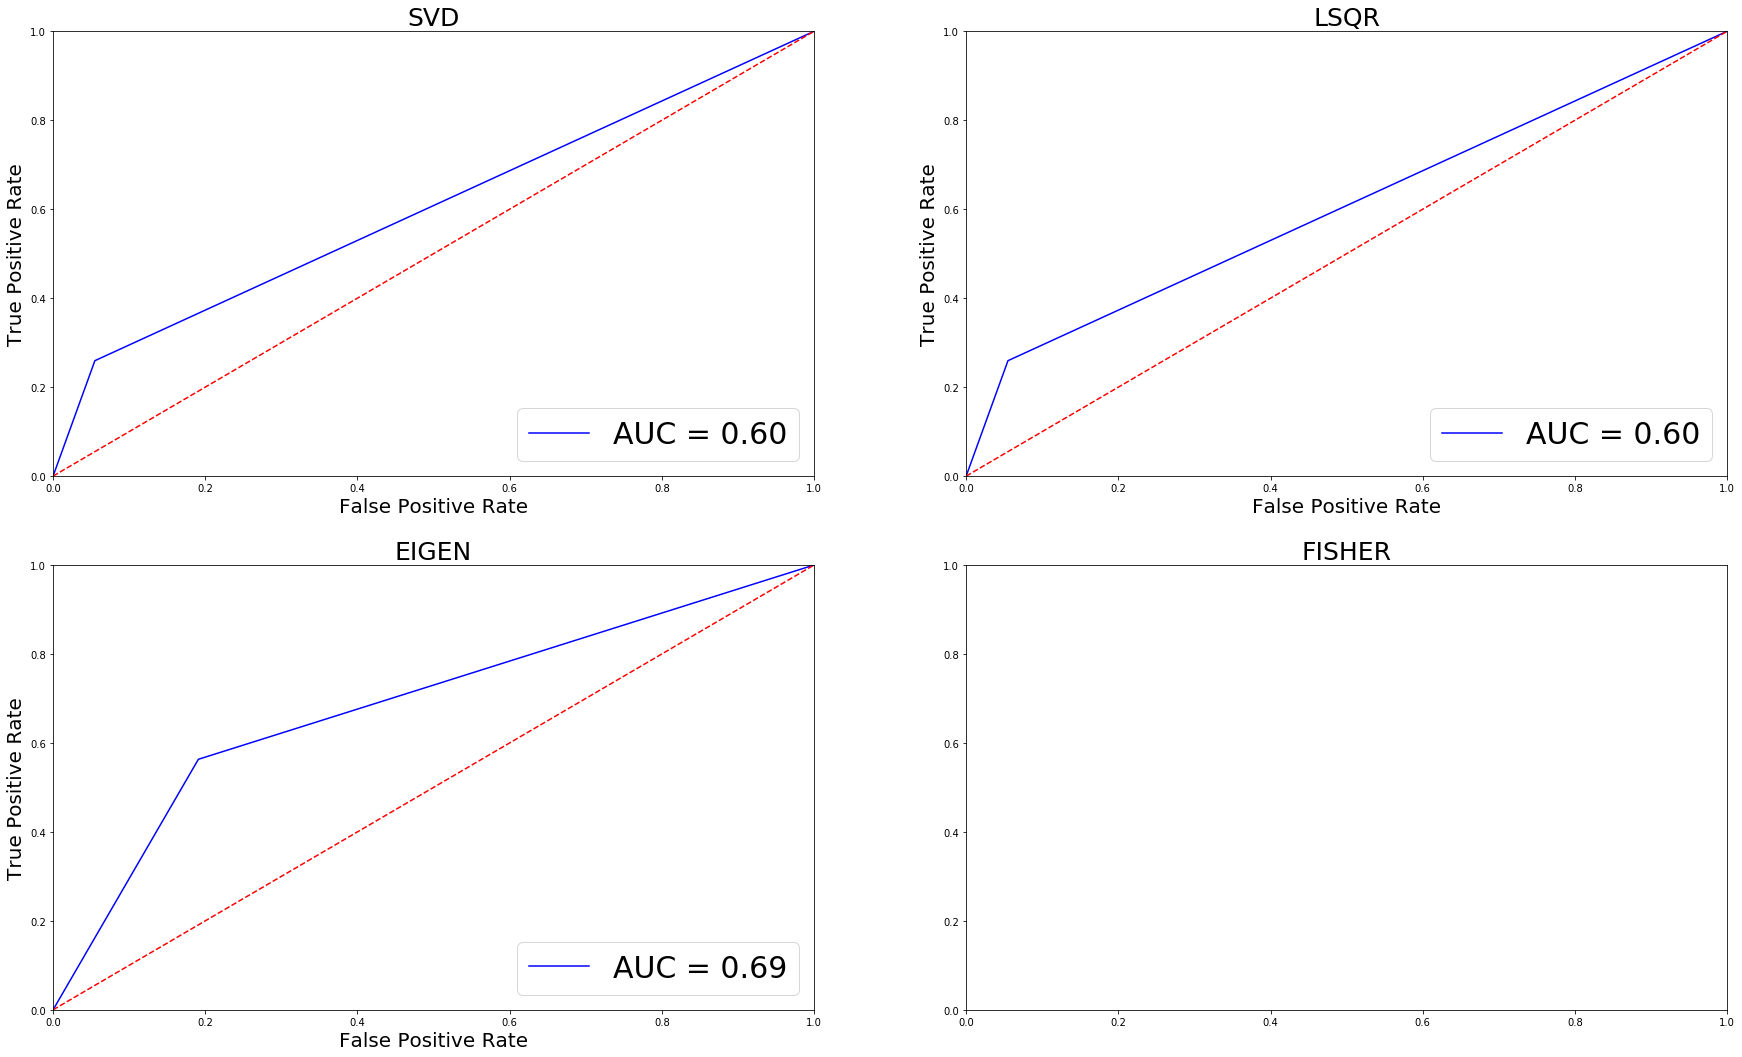

In [217]:
rocs = []
fprs = []
tprs = []
thresholds = []
for pred in pred_classes:
#     rocs.append(metrics.roc_auc_score(y_test, pred[:,1], average = 'weighted'))
#     fpr, tpr, thr = metrics.roc_curve(y_test, pred[:,1], pos_label=1)
    rocs.append(metrics.roc_auc_score(y_valid, pred, average = 'weighted'))
    fpr, tpr, thr = metrics.roc_curve(y_valid, pred, pos_label=1)
    fprs.append(fpr)
    tprs.append(tpr)
    thresholds.append(thr)
fig = plt.figure(figsize = (30,18))
for i, sv in enumerate(solvers):
    sp = (int) ('22'+str(i+1))
    plt.subplot(sp)
    plt.title(str(sv).upper(), fontsize = 25)
    plt.plot(fprs[i], tprs[i], 'b', label = 'AUC = %0.2f' % rocs[i])
    plt.legend(loc = 'lower right', fontsize = 30)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate', fontsize = 20)
    plt.xlabel('False Positive Rate', fontsize = 20)

plt.subplot(224)
fpr, tpr, thr = metrics.roc_curve(y_valid, pred_class_, pos_label=1)
acc = metrics.accuracy_score(y_valid, pred_class_)

plt.title('FISHER', fontsize = 25)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % auc)
plt.legend(loc = 'lower right', fontsize = 30)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate', fontsize = 15)
plt.xlabel('False Positive Rate', fontsize = 15)
plt.show()


Text(0,0.5,'Segundos')

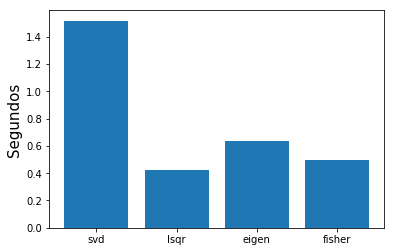

In [93]:
solvers.append('fisher')
times.append(t_fisher)
plt.bar(solvers, times)
plt.ylabel('Segundos', fontsize = 15)

## Varias mediciones

In [77]:
cm = []
y_valid = Subject['A']['y_valid']
pred_classes = Subject['A']['pred_classes']
for pred in pred_classes: 
    cm.append(metrics.confusion_matrix(y_valid, pred))
cm.append(metrics.confusion_matrix(y_valid, pred_class_))


In [103]:
cm = []
recall = []
accuracy = []
#precision = []
log_loss = []
fbeta = []
for pred in pred_classes: 
    cm.append(metrics.confusion_matrix(y_valid, pred))
    recall.append(metrics.recall_score(y_valid, pred))
    accuracy.append(metrics.accuracy_score(y_valid, pred))
 #   precision.append(metrics.precision_score(y_valid, pred))
    fbeta.append(metrics.fbeta_score(y_valid, pred,4))
for pred in predictions:
        log_loss.append(metrics.log_loss(y_valid, pred))
        
pred_class_ = clf.predict_class(X_valid)
cm.append(metrics.confusion_matrix(y_valid, pred_class_))
recall.append(metrics.recall_score(y_valid, pred_class_))
accuracy.append(metrics.accuracy_score(y_valid, pred_class_))
#precision.append(metrics.precision_score(y_valid, pred_class_))
fbeta.append(metrics.fbeta_score(y_valid, pred_class_,4))
log_loss.append(metrics.log_loss(y_valid, pred_[:,1]))



In [113]:
for subject in range(2):
    sbj = Subject[sb[subject]]
    cm = []
    recall = []
    accuracy = []
    #precision = []
    log_loss = []
    fbeta = []
    pred_clases = sbj['pred_classes'] 
    predictions = sbj['predictions']
    for pred in pred_classes: 
        cm.append(metrics.confusion_matrix(sbj['y_valid'], pred))
        recall.append(metrics.recall_score(sbj['y_valid'], pred))
        accuracy.append(metrics.accuracy_score(sbj['y_valid'], pred))
     #   precision.append(metrics.precision_score(y_valid, pred))
    for pred in predictions:
            log_loss.append(metrics.log_loss(sbj['y_valid'], pred[:,1]))
    sbj['cm'] = cm
    sbj['recall'] = recall
    sbj['accuracy'] = accuracy
    sbj['log_loss'] = log_loss
    



In [219]:
metrics.log_loss(y_valid, pred_[:,1])

0.57513302877031525

In [114]:
results = []
for subject in range(2):
    sbj = Subject[sb[subject]]
    df = {}
    for i, sv in enumerate(solvers):
        df[sv] = {'Recall': sbj['recall'][i], 'Accuracy': sbj['accuracy'][i], #'Precision': precision[i], 
                  'Log loss': sbj['log_loss'][i], 'Time [s]': sbj['times'][i]}
    df = pd.DataFrame(df)
    results.append(df)
df

,svd,lsqr,eigen,fisher
Accuracy,0.874728,0.874728,0.847277,0.792593
Log loss,0.315235,0.315246,0.516734,0.468829
Recall,0.507171,0.507171,0.672751,0.756193
Time [s],2.160007,0.677436,1.012929,0.731493


In [115]:
results[0]

,svd,lsqr,eigen,fisher
Accuracy,0.744009,0.744009,0.688235,0.632244
Log loss,0.428784,0.428804,1.229107,0.565468
Recall,0.122919,0.122919,0.202305,0.280410
Time [s],3.253280,0.628705,1.024296,0.778154


In [105]:
for subject in range(2):
    df = {}
    for i, sv in enumerate(solvers):
        df[sv] = {'Recall': recall[i], 'Accuracy': accuracy[i], #'Precision': precision[i], 
                  'Log loss': log_loss[i], 'Time [s]': times[i]}
df = pd.DataFrame(df)
df

IndexError: list index out of range

## Matriz de confusión

In [84]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title.upper(), fontsize = 18)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes, rotation = 90)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    #plt.tight_layout()
    plt.ylabel('Etiqueta verdadera', fontsize = 13)
    plt.xlabel('Etiqueta predicha', fontsize = 13)


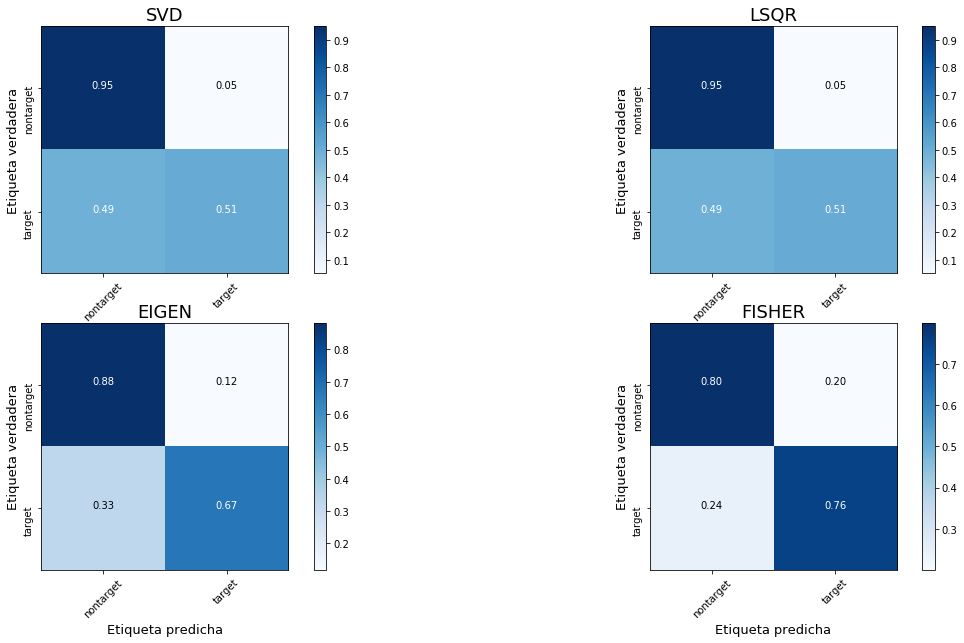

In [118]:
fig = plt.figure(figsize = (20, 10))
for i, sv in enumerate(solvers):
    sb = '22'+str(i+1)
    plt.subplot(sb)
    plot_confusion_matrix(Subject['B']['cm'][i], ['nontarget', 'target'],
                      title = sv, normalize = True)
 

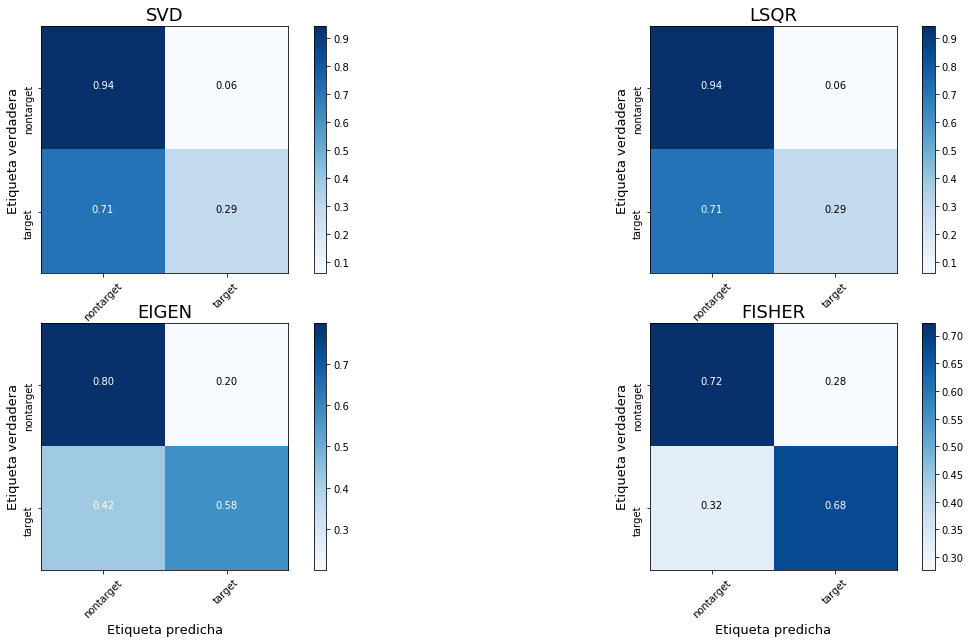

In [86]:
fig = plt.figure(figsize = (20, 10))
plt.subplot(221)
plot_confusion_matrix(cm[0], ['nontarget', 'target'],
                      title = solvers[0], normalize = True)
plt.subplot(222)
plot_confusion_matrix(cm[1], ['nontarget', 'target'],
                      title = solvers[1], normalize = True)
plt.subplot(223)
plot_confusion_matrix(cm[2], ['nontarget', 'target'],
                      title = solvers[2], normalize = True)
plt.subplot(224)
plot_confusion_matrix(cm[3], ['nontarget', 'target'],
                      title = solvers[3], normalize = True)


## Curva precision-recall

Text(0.5,1,'2-class Precision-Recall curve: AP=0.50')

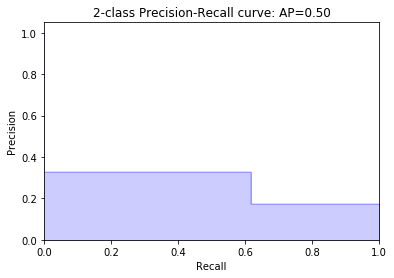

In [149]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
average_precision = metrics.average_precision_score(y_valid, pred_class_)
precision, recall, _ = precision_recall_curve(y_valid, pred_class_)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
         average_precision))

## Curva de aprendizaje

In [71]:
from sklearn.model_selection import learning_curve
from sklearn.svm import SVC

train_sizes, train_scores, valid_scores = learning_curve(LinearDiscriminantAnalysis(solver = 'lsqr'), X_train, y_train, 
                                                         train_sizes=[500, 1000, 5000, 8000], cv=5)

In [66]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt



Automatically created module for IPython interactive environment


<module 'matplotlib.pyplot' from 'C:\\Users\\sofis\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

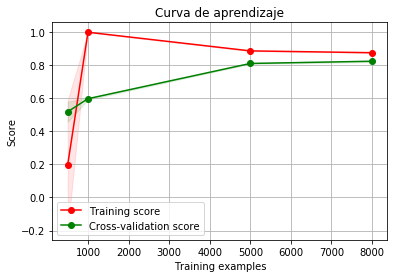

In [70]:
plot_learning_curve(LinearDiscriminantAnalysis(solver = 'lsqr'), 'Curva de aprendizaje', X_train, y_train, train_sizes=[500, 1000, 5000, 8000], cv = 5)

### Character prediction 

In [15]:
def predict_character(pred, n_characters, fv_test, labels):
    pred_target = pred
    #unscramble_idx = fv_test.stimulus_code.reshape(100, 15, 12).argsort()
    unscramble_idx = fv_test.stimulus_code.reshape(n_characters, -1, 12).argsort()
    static_idx = np.indices(unscramble_idx.shape)
    #lda_out_prob = pred.reshape(100, 15, 12)
    lda_out_prob = pred.reshape(n_characters, -1, 12)
    lda_out_prob = lda_out_prob[static_idx[0], static_idx[1], unscramble_idx]

    # destil the result of the 15 runs
    lda_out_prob = lda_out_prob.sum(axis=1)
    lda_out_prob = lda_out_prob.argsort()


    cols = lda_out_prob[lda_out_prob <= 5].reshape(n_characters, -1)
    rows = lda_out_prob[lda_out_prob > 5].reshape(n_characters, -1)
    text = ''
    for i in range(n_characters):
        row = rows[i][-1]-6
        col = cols[i][-1]
        letter = MATRIX[row][col]
        text += letter
    print()
    print('Constructed labels: %s' % text.upper())
    print('True labels       : %s' % labels)
    a = np.array(list(text.upper()))
    b = np.array(list(labels))
    accuracy = np.count_nonzero(a == b) / len(a)
    print('Accuracy: %.1f%%' % (accuracy * 100))

In [257]:
d = loadmat(TRAIN_A)

In [262]:
labelsA = d['TargetChar'][0]

In [330]:
pred2 = classifiers[2].predict_proba(fv_test.data)
predict_character(pred2[:,1], 100, fv_test, TRUE_LABELS_B)


Constructed labels: MERMIROOMUZJPXJOHUVFEORZP3GLOO7AUFDKEFTWEOOALZOP9ROCGZEO1Y19EWX65QUYU7NAK_3ACJDVDNGQXOJBBV2B5EFDIDTR
True labels       : MERMIROOMUHJPXJOHUVLEORZP3GLOO7AUFDKEFTWEOOALZOP9ROCGZET1Y19EWX65QUYU7NAK_4YCJDVDNGQXODBEV2B5EFDIDNR
Accuracy: 92.0%


In [13]:
import time
x_test = fv_test.data
clf = LDA()
t_start = time.clock()
clf.fit(X_train, y_train)
t_end = time.clock()
pred_ = clf.predict_proba(X_valid)
pred_class_ = clf.predict_class(X_valid)
t_fisher = t_end - t_start
score = clf.score(X_valid, y_valid)

In [22]:
pred2 = clf.predict_proba(fv_test.data)
predict_character(pred2[:,1], 100, fv_test, TRUE_LABELS_B)# TRUE_LABELS_A)


Constructed labels: MERMIROOMUZJPXJOHUVLBORZP3GLOO6AUFDKEFTWEOOALZOP9ROCGZE41Y19EWX65QUYU7NAK_3YCJDVDNGQXOJBEV2B5EFDIDNR
True labels       : MERMIROOMUHJPXJOHUVLEORZP3GLOO7AUFDKEFTWEOOALZOP9ROCGZET1Y19EWX65QUYU7NAK_4YCJDVDNGQXODBEV2B5EFDIDNR
Accuracy: 94.0%


In [19]:
dat_train = load_bci_data(TRAIN_B)
dat_test = load_bci_data(TEST_B)

fv_train, epo_train = preprocessing_simple(dat_train, MARKER_DEF_TRAIN, SEG_IVAL)
fv_test, _ = preprocessing_simple(dat_test, MARKER_DEF_TEST, SEG_IVAL)

x = fv_train.data #data
y = fv_train.axes[0] #labels
x_test = fv_test.data
y_test = fv_test.axes[0]
X_train, X_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.3, train_size = 0.7)

In [20]:
clf = LDA()
clf.fit(X_train, y_train)

In [21]:
pred2 = classifiers[2].predict_proba(fv_test.data)
predict_character(pred2[:,1], 100, fv_test, TRUE_LABELS_B)

NameError: name 'classifiers' is not defined

In [304]:
import time 

solvers = ['svd', 'lsqr', 'eigen']
scores = []
predictions = []
pred_classes = []
times = []
classifiers = []
for sv in solvers:
    cf = LinearDiscriminantAnalysis(solver = sv)
    t_start = time.clock()
    classifiers.append(cf.fit(X_train, y_train))
    predictions.append(cf.predict_proba(X_valid))
    t_end = time.clock()
    pred_classes.append(cf.predict(X_valid))
    scores.append(cf.score(X_valid, y_valid))
    t_diff = t_end - t_start
    times.append(t_diff)
    print('Time for solver {}: {} s'.format(sv, t_diff))

Time for solver svd: 1.4083756349536998 s
Time for solver lsqr: 0.43486252519142 s
Time for solver eigen: 0.5728328326149494 s


In [309]:
clf

In [319]:
pred2 = clf.predict_proba(fv_test.data)
predict_character(pred2, 100, fv_test, TRUE_LABELS_B)# TRUE_LABELS_A)


Constructed labels: CXKQY1315LAUZJ5NAJKG172Y1_EIR3V5ROM1BCEQUP1Q98KH4XOCI_X76K1GCIPM53XIMQM64LSNDSN__JNRIWA9QL8VFGUGOUPG
True labels       : MERMIROOMUHJPXJOHUVLEORZP3GLOO7AUFDKEFTWEOOALZOP9ROCGZET1Y19EWX65QUYU7NAK_4YCJDVDNGQXODBEV2B5EFDIDNR
Accuracy: 4.0%


## pred2

In [20]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import LinearSVC
import time
def SVM(x, y, x_test, y_test):
    clf = CalibratedClassifierCV(base_estimator=LinearSVC(), cv=2)
    t_start = time.clock()
    clf.fit(x, y)
    pred = clf.predict_proba(x_test)
    t_end = time.clock()
    print(clf.score(x_test, y_test), 'time: {} seconds'.format(t_end - t_start))
    return pred


In [25]:
from sklearn.preprocessing import normalize
pred = SVM(normalize(x, axis = 1), y,normalize(x_test, axis = 1), y_test)

0.9572777777777778 time: 1.821018300602276 seconds


## Comparison Scikitlearn LDA and Mine

In [162]:
import time
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
cf = LinearDiscriminantAnalysis()
t_start = time.clock()
cf.fit(x,y)
pred1 = cf.predict_proba(x_test)
pred_class = cf.predict(x_test)
t_end = time.clock()

print('Time: {} s'.format(t_end - t_start))

Time: 2.1207154807880215 s


In [163]:
y_test = fv_test.axes[0]
pred_class.shape

(18000,)

In [160]:
p = pred_class[y_test == 1]

In [18]:
import time
cf = LDA()
t_start = time.clock()
cf.fit(x,y)
pred2 = cf.predict_proba(x_test)
t_end = time.clock()

print('Time: {} s'.format(t_end - t_start))

Time: 0.6235795543434417 s


In [19]:
print('\nSklearn LDA')
predict_character(pred1[:,1], 100, TRUE_LABELS_A)


Sklearn LDA

Constructed labels: WQXPLZCOMRKO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOUOJD2UFYPOO6J7LDAYEGOA5VHNE9BWXOO1TDOILUEE5BFAREXAWRK4R3MRU
True labels       : WQXPLZCOMRKO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDGYEGOA5VHNEHBTXOO1TDOILUEE5BFAEEXAW_K4R3MRU
Accuracy: 94.0%


In [20]:
print('\nMy LDA')
predict_character(pred2, 100, TRUE_LABELS_A)


My LDA

Constructed labels: WQXPLZCOMRKOW7YFZDEZ1DPI9NNVGRPDJCUVRMEUOOOJD2UFYPOO6J7LDGYEGOA5VTNEHBWXOO1TDOILUEE5BFAFEXAW_K3R3MRU
True labels       : WQXPLZCOMRKO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDGYEGOA5VHNEHBTXOO1TDOILUEE5BFAEEXAW_K4R3MRU
Accuracy: 94.0%


In [36]:
from sklearn.preprocessing import normalize
x_norm = normalize(x, axis = 1)
x_test_norm = normalize(x_test, axis = 1)

In [24]:
import time
cf = LDA()
t_start = time.clock()
cf.fit(x_norm,y)
pred_norm = cf.predict_proba(x_test_norm)
t_end = time.clock()

print('Time: {} s'.format(t_end - t_start))

Time: 0.6077991319885925 s


In [25]:
print('\nNormalized LDA')
predict_character(pred_norm, 100, TRUE_LABELS_A)


Normalized LDA

Constructed labels: WQXPLZCOMRKOW7YFZDEZ1DPI9NNVGRPDJCUVRMEUOOOJD2UFYPOO6J7LDAYEGOA5VTNEHBWXOO1TDOILUEE5NFAFEXAW_K4R3MRU
True labels       : WQXPLZCOMRKO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDGYEGOA5VHNEHBTXOO1TDOILUEE5BFAEEXAW_K4R3MRU
Accuracy: 93.0%


In [29]:
from sklearn.calibration import CalibratedClassifierCV
import time

clf = CalibratedClassifierCV(base_estimator=LinearDiscriminantAnalysis(), cv=2)
t_start = time.clock()
clf.fit(x, y)
pred_cv = clf.predict_proba(x_test)
t_end = time.clock()
print(clf.score(x_test, y_test), 'time: {} seconds'.format(t_end - t_start))


0.9945 time: 2.5491716686265136 seconds


In [47]:
from sklearn.calibration import CalibratedClassifierCV
import time

clf = CalibratedClassifierCV(base_estimator=LinearDiscriminantAnalysis(), cv=2)
t_start = time.clock()
clf.fit(x_norm, y)
pred_cv_norm = clf.predict_proba(x_test_norm)
t_end = time.clock()
print(clf.score(x_test_norm, y_test), 'time: {} seconds'.format(t_end - t_start))


0.9693333333333334 time: 2.479255164519998 seconds


In [42]:
print('\nCV = 2 LDA')
predict_character(pred_cv[:,1], 100, TRUE_LABELS_A)


CV = 2 LDA

Constructed labels: WQXPLZCOMRKO97YFZDEZ1DPI9NNVGRPDJCUVRMEUOOOJD2UFYPOO6J7LDAYEGOA5VHNEHBWXOOZTDOILUEE5AFAEEXAW_K4R3MRU
True labels       : WQXPLZCOMRKO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDGYEGOA5VHNEHBTXOO1TDOILUEE5BFAEEXAW_K4R3MRU
Accuracy: 95.0%


In [48]:
print('\nCV = 2 LDA')
predict_character(pred_cv_norm[:,1], 100, TRUE_LABELS_A)


CV = 2 LDA

Constructed labels: WQXPLZCOMRKO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDAYEGOA5VTNEHBTXOO1TDOILUEE5HFAFEXAW7K4R3MRU
True labels       : WQXPLZCOMRKO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDGYEGOA5VHNEHBTXOO1TDOILUEE5BFAEEXAW_K4R3MRU
Accuracy: 95.0%


## Con menos canales

In [27]:
def sel_channels(dat, c_list, chanaxis=-1):
    chan_mask = np.array([False for i in range(len(dat.axes[chanaxis]))])
    for c in c_list:
        idx = list(dat.axes[-1]).index(c)
        chan_mask[idx] = True
    data = dat.data.compress(chan_mask, chanaxis)
    channs = dat.axes[chanaxis][chan_mask]
    axes = dat.axes[:]
    axes[-1] = channs
    #class_names = dat.class_names
    #dat.class_names = class_names
    return dat.copy(data=data, axes=axes)


In [86]:
channel_list = ['Cz', 'P3', 'Pz', 'P4', 'POz', 'O1', 'Oz', 'O2']
channel_list = ['Cz', 'P3', 'Pz', 'P4', 'POz', 'O1', 'Oz', 'O2']

dat_train_A = sel_channels(dat_train, channel_list)
dat_test_A = sel_channels(dat_test, channel_list)

fv_train_A, epo_A = preprocessing_simple(dat_train_A, MARKER_DEF_TRAIN, SEG_IVAL)
fv_test_A, _ = preprocessing_simple(dat_test_A, MARKER_DEF_TEST, SEG_IVAL)

In [142]:
x = fv_train_A.data #traininig samples
y = fv_train_A.axes[0] #class labels
x_test = fv_test_A.data #traininig samples
y_test = fv_test_A.axes[0] #class labels

In [91]:
import time
cf = LDA()
t_start = time.clock()
cf.fit(x,y)
pred = cf.predict_proba(x_test)
t_end = time.clock()

print('Time: {} s'.format(t_end - t_start))

Time: 0.033647530934558745 s


In [92]:
print('\nLDA')
predict_character(pred, 100, TRUE_LABELS_A)


LDA

Constructed labels: WQXPLZUOMRKUX7YFZDEZ1DPI9NNVGRPDJUUJ4MEUOIOJJ2IFYPOO5H7LDGYEAOA5VHNEJBQFOO1TDOCLUEE5BFA4EXAW_K3Q3MRU
True labels       : WQXPLZCOMRKO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDGYEGOA5VHNEHBTXOO1TDOILUEE5BFAEEXAW_K4R3MRU
Accuracy: 80.0%


## Con trials por época de caracter NOT WORKING

In [141]:
data_train = dat_train.data.reshape(85,-1,64)[:,0:5004].reshape(-1,64)
data_test = dat_test.data.reshape(100,-1,64)[:,0:5004].reshape(-1,64)
ax_train = dat_train.axes[:]
ax_train[0] = dat_train.axes[0][0:(5004*85)]
ax_test = dat_test.axes[:]
ax_test[0] = dat_test.axes[0][0:(5004*100)]
dat_train = dat_train.copy(data = data_train, axes = ax_train)
dat_test = dat_test.copy(data = data_test, axes = ax_test)
fv_train_A, epo_A = preprocessing_simple(dat_train, MARKER_DEF_TRAIN, SEG_IVAL)
fv_test_A, _ = preprocessing_simple(dat_test, MARKER_DEF_TEST, SEG_IVAL)

In [143]:
x = fv_train_A.data #traininig samples
y = fv_train_A.axes[0] #class labels
x_test = fv_test_A.data #traininig samples
y_test = fv_test_A.axes[0] #class labels

In [144]:
import time
cf = LDA()
t_start = time.clock()
cf.fit(x,y)
pred = cf.predict_proba(x_test)
t_end = time.clock()

print('Time: {} s'.format(t_end - t_start))

Time: 0.48673207756655756 s


In [145]:
print('\nLDA')
predict_character(pred, 100, TRUE_LABELS_A)


LDA


ValueError: cannot reshape array of size 11554 into shape (100,newaxis,12)

In [147]:
fv_train_A.data.shape

(9823, 896)